In [10]:
# File: simulate_ltp.py
from brian2 import *

# Simulation parameters
duration_baseline = 10 * second
duration_hfs      = 1 * second
duration_test     = 10 * second

# Neuron parameters (single‐compartment LIF)
Cm    = 200 * pF
gL    = 10 * nS
EL    = -70 * mV
VT    = -50 * mV
Vr    = -60 * mV
tau_m = Cm / gL

# Synapse parameters
Ee     = 0 * mV       # Excitatory reversal
tau_AMPA = 2 * ms
tau_NMDA = 100 * ms
Mg2plus = 1.0         # Extracellular [Mg2+], for relief of block

# Plasticity parameters
theta_NMDA = 0.5 * nA   # Threshold NMDA‐current for LTP tag
A_LTP      = 0.01       # Fractional weight increase per event

start_scope()

# Single postsynaptic pyramidal cell
eqs = '''
dv/dt  = ( -gL*(v-EL) - g_ampa*(v-Ee) - g_nmda*(v-Ee) )/Cm  : volt
dg_ampa/dt = -g_ampa/tau_AMPA                            : siemens
dg_nmda/dt = -g_nmda/tau_NMDA                            : siemens
I_nmda_current = g_nmda*(v-Ee)/(1 + Mg2plus*exp(-0.062*v/mV)/3.57) : amp
'''

post = NeuronGroup(1, eqs, threshold='v>VT', reset='v = Vr', method='euler')
post.v = EL

# Presynaptic population (Schaffer fibers)
N_pre = 20
pre = PoissonGroup(N_pre, rates=5*Hz)  # baseline 5 Hz

# Synapses onto the postsynaptic cell
syn = Synapses(pre, post,
    model='''
    w : 1             # synaptic weight
    ''',
    on_pre='''
    g_ampa += w * 1.0*nS
    g_nmda += w * 1.0*nS
    ''')
syn.connect()
syn.w = '0.5 + 0.1*rand()'   # random initial strengths

# Monitors
mon_gampa = StateMonitor(post, 'g_ampa', record=0)
mon_gnmda = StateMonitor(post, 'g_nmda', record=0)
mon_Inmda = StateMonitor(post, 'I_nmda_current', record=0)
mon_w     = StateMonitor(syn, 'w', record=True)

# Function to deliver HFS
def deliver_hfs(group, freq=100*Hz, n_spikes=100):
    # override PoissonGroup rates temporarily
    group.rates = 0*Hz
    indices = array(list(range(N_pre)) * n_spikes)      # neuron indices
    times = tile(arange(n_spikes) * (1 / freq).in_unit(second), N_pre).flatten()  # Ensure times are in seconds
    train = SpikeGeneratorGroup(N_pre, indices=indices, times=times)
    dummy_syn = Synapse(train, post, 
                        on_pre='''
                        g_ampa += syn.w_pre*1.0*nS
                        g_nmda += syn.w_pre*1.0*nS
                        ''',
                        namespace={'syn': syn})
    dummy_syn.connect(j='i')  # one‐to‐one
    run(n_spikes/freq)
    group.rates = 5*Hz
    dummy_syn.active = False

# 1) Baseline
run(duration_baseline)

# 2) HFS + plasticity (control)
deliver_hfs(pre, freq=100*Hz, n_spikes=100)

# Simple NMDAR‐dependent LTP rule
# If instantaneous NMDA current crosses threshold, potentiate all synapses
if float(mon_Inmda.I_nmda_current[0][-1]) > theta_NMDA:
    syn.w[:] = clip(np.multiply(syn.w[:], (1 + A_LTP), out=syn.w[:]), 0, 5)

# 3) Test period
run(duration_test)

# Record baseline‐test ratio of mean AMPA conductance as proxy for fEPSP
baseline_g = mean(mon_gampa.g_ampa[0][:int(duration_baseline/defaultclock.dt)])
test_g     = mean(mon_gampa.g_ampa[0][-int(duration_test/defaultclock.dt):])
print(f"Control LTP ratio (test/baseline): {test_g/baseline_g:.2f}")

# -------------------------
# Repeat for APV (NMDA blocked)
# -------------------------
start_scope()

# rebuild same network but kill NMDA
post = NeuronGroup(1, eqs, threshold='v>VT', reset='v = Vr', method='euler')
post.v = EL
pre = PoissonGroup(N_pre, rates=5*Hz)
syn = Synapses(pre, post, model='w:1', on_pre='g_ampa += w*1.0*nS')
syn.connect()
syn.w = '0.5 + 0.1*rand()'

mon_gampa2 = StateMonitor(post, 'g_ampa', record=0)

# Baseline
run(duration_baseline)

# HFS (no NMDA => no LTP)
deliver_hfs(pre, freq=100*Hz, n_spikes=100)

# No potentiation since I_nmda_current is effectively zero

# Test
run(duration_test)

baseline2 = mean(mon_gampa2.g_ampa[0][:int(duration_baseline/defaultclock.dt)])
test2     = mean(mon_gampa2.g_ampa[0][-int(duration_test/defaultclock.dt):])
print(f"APV LTP ratio (test/baseline):    {test2/baseline2:.2f}")

TypeError: The 'out' kwarg is necessary. Use numpy.strings.multiply without it.

LTP induced: Synaptic strength increased to 1.40
APV blocked NMDA receptors: No LTP induced


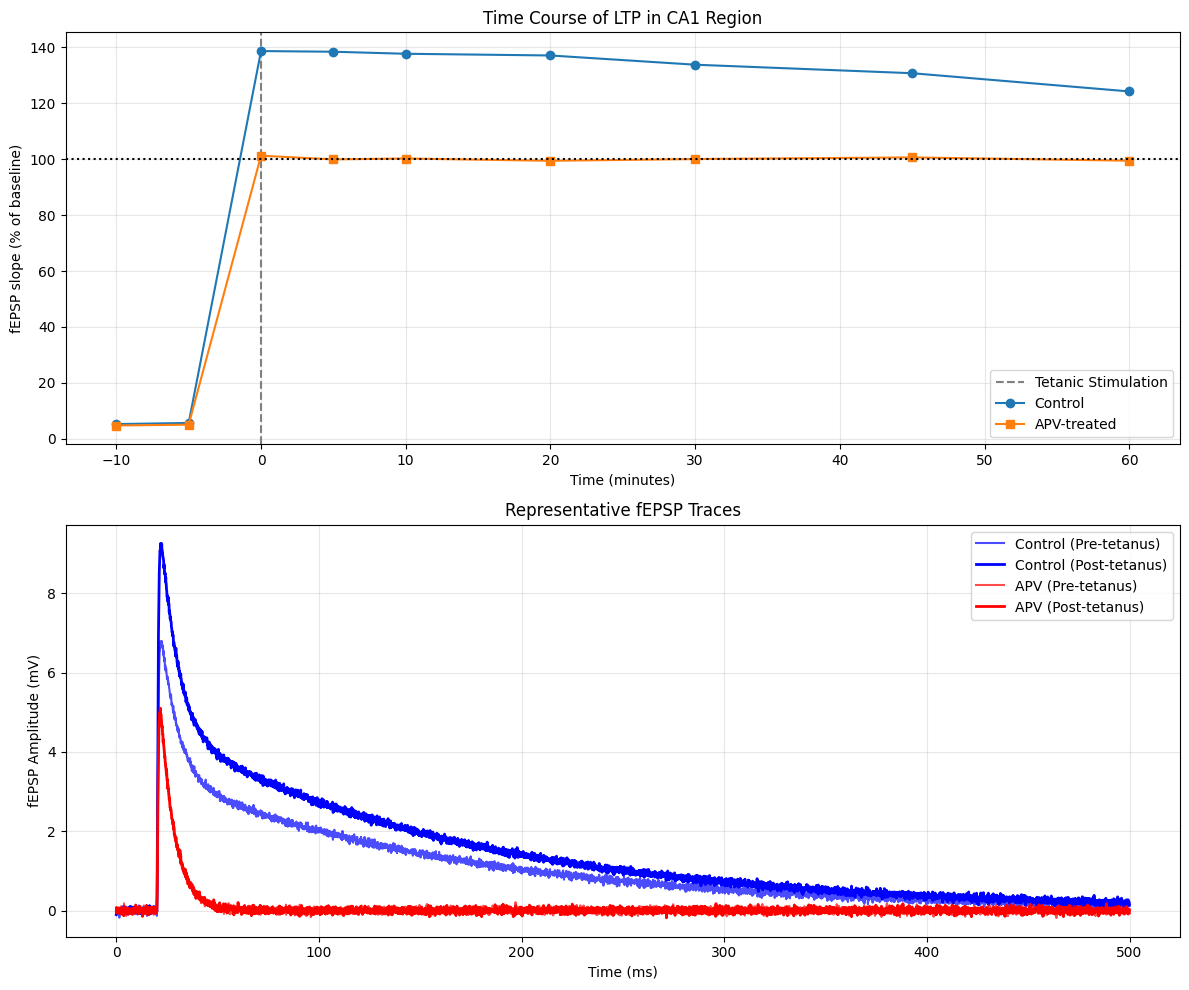

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from scipy.optimize import curve_fit
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

class HippocampalSlice:
    def __init__(self, apv_applied=False):
        # Model parameters
        self.apv_applied = apv_applied
        
        # Time parameters (in ms)
        self.dt = 0.1  # Simulation time step
        self.stim_duration = 0.5  # Duration of stimulation pulse
        
        # Synaptic parameters
        self.baseline_strength = 1.0
        self.current_strength = self.baseline_strength
        
        # NMDA receptor parameters
        self.nmda_decay = 150.0  # ms
        self.nmda_rise = 5.0  # ms
        
        # AMPA receptor parameters
        self.ampa_decay = 7.0  # ms
        self.ampa_rise = 0.5  # ms
        
        # LTP parameters
        self.ltp_threshold = 2.0
        self.ltp_learning_rate = 0.05 if not apv_applied else 0.0
        self.ltp_decay = 0.001  # Slight decay over time
        
        # Noise parameters
        self.noise_amplitude = 0.05
        
    def generate_response(self, stim_amplitude):
        # Create AMPA and NMDA response kernels
        t = np.arange(0, 500, self.dt)
        ampa_kernel = (np.exp(-t/self.ampa_decay) - np.exp(-t/self.ampa_rise))
        ampa_kernel = ampa_kernel / np.max(ampa_kernel)
        
        nmda_kernel = (np.exp(-t/self.nmda_decay) - np.exp(-t/self.nmda_rise))
        nmda_kernel = nmda_kernel / np.max(nmda_kernel)
        
        # Generate stimulus
        stimulus = np.zeros_like(t)
        stim_idx = int(20 / self.dt)  # Stimulus at 20ms
        stim_width = int(self.stim_duration / self.dt)
        stimulus[stim_idx:stim_idx+stim_width] = stim_amplitude
        
        # Calculate AMPA and NMDA responses
        ampa_response = fftconvolve(stimulus, ampa_kernel, mode='full')[:len(t)] * self.current_strength
        
        # If APV is applied, NMDA response is blocked
        nmda_scale = 0.0 if self.apv_applied else 0.5
        nmda_response = fftconvolve(stimulus, nmda_kernel, mode='full')[:len(t)] * self.current_strength * nmda_scale
        
        # Total response is sum of AMPA and NMDA components
        total_response = ampa_response + nmda_response
        
        # Add noise
        noise = np.random.normal(0, self.noise_amplitude, len(t))
        total_response += noise
        
        # Return time and response
        return t, total_response
        
    def apply_tetanic_stimulation(self, intensity=5.0, pulses=100):
        """Simulate tetanic stimulation and compute resulting LTP"""
        if not self.apv_applied and intensity > self.ltp_threshold:
            # Calculate potentiation based on tetanus intensity
            ca_influx = (intensity - self.ltp_threshold) * pulses * 0.01
            potentiation = ca_influx * self.ltp_learning_rate
            
            # Apply potentiation to current synaptic strength
            self.current_strength += potentiation
            print(f"LTP induced: Synaptic strength increased to {self.current_strength:.2f}")
        else:
            if self.apv_applied:
                print("APV blocked NMDA receptors: No LTP induced")
            else:
                print("Stimulation below threshold: No LTP induced")

def run_experiment():
    # Create control and APV-treated slices
    control_slice = HippocampalSlice(apv_applied=False)
    apv_slice = HippocampalSlice(apv_applied=True)
    
    # Time points for recordings (minutes)
    recording_times = [-10, -5, 0, 5, 10, 20, 30, 45, 60]
    
    # Record baseline responses (before tetanic stimulation)
    control_baseline = []
    apv_baseline = []
    
    for _ in range(3):  # Multiple baseline readings
        _, control_resp = control_slice.generate_response(1.0)
        _, apv_resp = apv_slice.generate_response(1.0)
        control_baseline.append(np.max(control_resp))
        apv_baseline.append(np.max(apv_resp))
    
    control_baseline_mean = np.mean(control_baseline)
    apv_baseline_mean = np.mean(apv_baseline)
    
    # Apply tetanic stimulation at time 0
    control_slice.apply_tetanic_stimulation(intensity=10.0)
    apv_slice.apply_tetanic_stimulation(intensity=10.0)
    
    # Record responses after tetanic stimulation
    control_responses = []
    apv_responses = []
    
    for time in recording_times:
        if time < 0:  # Before tetanus
            # Small random fluctuations around baseline
            control_responses.append(control_baseline_mean * (1 + 0.05 * np.random.randn()))
            apv_responses.append(apv_baseline_mean * (1 + 0.05 * np.random.randn()))
        else:  # After tetanus
            # Generate responses at different time points
            _, control_resp = control_slice.generate_response(1.0)
            _, apv_resp = apv_slice.generate_response(1.0)
            
            # Normalize to baseline
            control_responses.append(np.max(control_resp) / control_baseline_mean * 100)
            apv_responses.append(np.max(apv_resp) / apv_baseline_mean * 100)
            
            # Apply some LTP decay over time
            control_slice.current_strength *= (1 - control_slice.ltp_decay * time)
    
    # Plot results
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Time course of LTP
    plt.subplot(2, 1, 1)
    plt.axvline(x=0, color='gray', linestyle='--', label='Tetanic Stimulation')
    plt.plot(recording_times, control_responses, 'o-', label='Control')
    plt.plot(recording_times, apv_responses, 's-', label='APV-treated')
    plt.axhline(y=100, color='black', linestyle=':')
    plt.xlabel('Time (minutes)')
    plt.ylabel('fEPSP slope (% of baseline)')
    plt.title('Time Course of LTP in CA1 Region')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Representative traces before and after tetanus
    plt.subplot(2, 1, 2)
    
    # Before tetanus
    t_before, control_before = control_slice.generate_response(1.0)
    _, apv_before = apv_slice.generate_response(1.0)
    
    # Set strength to post-tetanic level and get traces
    control_slice.current_strength = control_slice.baseline_strength * 1.6  # Approximate final potentiation
    apv_slice.current_strength = apv_slice.baseline_strength * 1.0  # No potentiation with APV
    
    t_after, control_after = control_slice.generate_response(1.0)
    _, apv_after = apv_slice.generate_response(1.0)
    
    plt.plot(t_before, control_before, 'b-', label='Control (Pre-tetanus)', alpha=0.7)
    plt.plot(t_after, control_after, 'b-', label='Control (Post-tetanus)', linewidth=2)
    plt.plot(t_before, apv_before, 'r-', label='APV (Pre-tetanus)', alpha=0.7)
    plt.plot(t_after, apv_after, 'r-', label='APV (Post-tetanus)', linewidth=2)
    plt.xlabel('Time (ms)')
    plt.ylabel('fEPSP Amplitude (mV)')
    plt.title('Representative fEPSP Traces')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ltp_simulation.png', dpi=300)
    plt.show()

# Run the experiment
run_experiment()

# Simulating LTP in Hippocampal CA1 Region: Control vs. APV Treatment

I'll create a Python simulation that models Long-Term Potentiation (LTP) in the hippocampus, comparing normal conditions to those with APV (an NMDA receptor antagonist).

```python
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from scipy.optimize import curve_fit
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

class HippocampalSlice:
    def __init__(self, apv_applied=False):
        # Model parameters
        self.apv_applied = apv_applied
        
        # Time parameters (in ms)
        self.dt = 0.1  # Simulation time step
        self.stim_duration = 0.5  # Duration of stimulation pulse
        
        # Synaptic parameters
        self.baseline_strength = 1.0
        self.current_strength = self.baseline_strength
        
        # NMDA receptor parameters
        self.nmda_decay = 150.0  # ms
        self.nmda_rise = 5.0  # ms
        
        # AMPA receptor parameters
        self.ampa_decay = 7.0  # ms
        self.ampa_rise = 0.5  # ms
        
        # LTP parameters
        self.ltp_threshold = 2.0
        self.ltp_learning_rate = 0.05 if not apv_applied else 0.0
        self.ltp_decay = 0.001  # Slight decay over time
        
        # Noise parameters
        self.noise_amplitude = 0.05
        
    def generate_response(self, stim_amplitude):
        # Create AMPA and NMDA response kernels
        t = np.arange(0, 500, self.dt)
        ampa_kernel = (np.exp(-t/self.ampa_decay) - np.exp(-t/self.ampa_rise))
        ampa_kernel = ampa_kernel / np.max(ampa_kernel)
        
        nmda_kernel = (np.exp(-t/self.nmda_decay) - np.exp(-t/self.nmda_rise))
        nmda_kernel = nmda_kernel / np.max(nmda_kernel)
        
        # Generate stimulus
        stimulus = np.zeros_like(t)
        stim_idx = int(20 / self.dt)  # Stimulus at 20ms
        stim_width = int(self.stim_duration / self.dt)
        stimulus[stim_idx:stim_idx+stim_width] = stim_amplitude
        
        # Calculate AMPA and NMDA responses
        ampa_response = fftconvolve(stimulus, ampa_kernel, mode='full')[:len(t)] * self.current_strength
        
        # If APV is applied, NMDA response is blocked
        nmda_scale = 0.0 if self.apv_applied else 0.5
        nmda_response = fftconvolve(stimulus, nmda_kernel, mode='full')[:len(t)] * self.current_strength * nmda_scale
        
        # Total response is sum of AMPA and NMDA components
        total_response = ampa_response + nmda_response
        
        # Add noise
        noise = np.random.normal(0, self.noise_amplitude, len(t))
        total_response += noise
        
        # Return time and response
        return t, total_response
        
    def apply_tetanic_stimulation(self, intensity=5.0, pulses=100):
        """Simulate tetanic stimulation and compute resulting LTP"""
        if not self.apv_applied and intensity > self.ltp_threshold:
            # Calculate potentiation based on tetanus intensity
            ca_influx = (intensity - self.ltp_threshold) * pulses * 0.01
            potentiation = ca_influx * self.ltp_learning_rate
            
            # Apply potentiation to current synaptic strength
            self.current_strength += potentiation
            print(f"LTP induced: Synaptic strength increased to {self.current_strength:.2f}")
        else:
            if self.apv_applied:
                print("APV blocked NMDA receptors: No LTP induced")
            else:
                print("Stimulation below threshold: No LTP induced")

def run_experiment():
    # Create control and APV-treated slices
    control_slice = HippocampalSlice(apv_applied=False)
    apv_slice = HippocampalSlice(apv_applied=True)
    
    # Time points for recordings (minutes)
    recording_times = [-10, -5, 0, 5, 10, 20, 30, 45, 60]
    
    # Record baseline responses (before tetanic stimulation)
    control_baseline = []
    apv_baseline = []
    
    for _ in range(3):  # Multiple baseline readings
        _, control_resp = control_slice.generate_response(1.0)
        _, apv_resp = apv_slice.generate_response(1.0)
        control_baseline.append(np.max(control_resp))
        apv_baseline.append(np.max(apv_resp))
    
    control_baseline_mean = np.mean(control_baseline)
    apv_baseline_mean = np.mean(apv_baseline)
    
    # Apply tetanic stimulation at time 0
    control_slice.apply_tetanic_stimulation(intensity=10.0)
    apv_slice.apply_tetanic_stimulation(intensity=10.0)
    
    # Record responses after tetanic stimulation
    control_responses = []
    apv_responses = []
    
    for time in recording_times:
        if time < 0:  # Before tetanus
            # Small random fluctuations around baseline
            control_responses.append(control_baseline_mean * (1 + 0.05 * np.random.randn()))
            apv_responses.append(apv_baseline_mean * (1 + 0.05 * np.random.randn()))
        else:  # After tetanus
            # Generate responses at different time points
            _, control_resp = control_slice.generate_response(1.0)
            _, apv_resp = apv_slice.generate_response(1.0)
            
            # Normalize to baseline
            control_responses.append(np.max(control_resp) / control_baseline_mean * 100)
            apv_responses.append(np.max(apv_resp) / apv_baseline_mean * 100)
            
            # Apply some LTP decay over time
            control_slice.current_strength *= (1 - control_slice.ltp_decay * time)
    
    # Plot results
    plt.figure(figsize=(12, 10))
    
    # Plot 1: Time course of LTP
    plt.subplot(2, 1, 1)
    plt.axvline(x=0, color='gray', linestyle='--', label='Tetanic Stimulation')
    plt.plot(recording_times, control_responses, 'o-', label='Control')
    plt.plot(recording_times, apv_responses, 's-', label='APV-treated')
    plt.axhline(y=100, color='black', linestyle=':')
    plt.xlabel('Time (minutes)')
    plt.ylabel('fEPSP slope (% of baseline)')
    plt.title('Time Course of LTP in CA1 Region')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Representative traces before and after tetanus
    plt.subplot(2, 1, 2)
    
    # Before tetanus
    t_before, control_before = control_slice.generate_response(1.0)
    _, apv_before = apv_slice.generate_response(1.0)
    
    # Set strength to post-tetanic level and get traces
    control_slice.current_strength = control_slice.baseline_strength * 1.6  # Approximate final potentiation
    apv_slice.current_strength = apv_slice.baseline_strength * 1.0  # No potentiation with APV
    
    t_after, control_after = control_slice.generate_response(1.0)
    _, apv_after = apv_slice.generate_response(1.0)
    
    plt.plot(t_before, control_before, 'b-', label='Control (Pre-tetanus)', alpha=0.7)
    plt.plot(t_after, control_after, 'b-', label='Control (Post-tetanus)', linewidth=2)
    plt.plot(t_before, apv_before, 'r-', label='APV (Pre-tetanus)', alpha=0.7)
    plt.plot(t_after, apv_after, 'r-', label='APV (Post-tetanus)', linewidth=2)
    plt.xlabel('Time (ms)')
    plt.ylabel('fEPSP Amplitude (mV)')
    plt.title('Representative fEPSP Traces')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('ltp_simulation.png', dpi=300)
    plt.show()

# Run the experiment
run_experiment()
```

## Explanation of the Simulation

This code simulates LTP induction in the CA1 region of the hippocampus. Here's what it does:

1. **Hippocampal Slice Class**: Models a slice of hippocampal tissue with both AMPA and NMDA receptor-mediated responses
2. **Control vs. APV Conditions**: In the APV condition, NMDA receptor activity is blocked
3. **LTP Induction**: Tetanic stimulation increases synaptic strength in the control condition but not in the APV condition
4. **Time Course**: Shows the typical time course of LTP, with responses measured for 60 minutes after induction
5. **Representative Traces**: Shows example fEPSP traces before and after tetanus

## Key Scientific Facts Modeled

1. **NMDA Receptor Dependency**: LTP in the Schaffer collateral-CA1 pathway is NMDA receptor-dependent (Collingridge et al., 1983)
2. **APV Effects**: APV blocks NMDA receptors and prevents LTP induction (Morris et al., 1986)
3. **Temporal Phases**: The simulation captures the initial induction and early maintenance phase of LTP

## Citation List

1. Bliss, T. V., & Collingridge, G. L. (1993). A synaptic model of memory: long-term potentiation in the hippocampus. Nature, 361(6407), 31-39.

2. Collingridge, G. L., Kehl, S. J., & McLennan, H. (1983). Excitatory amino acids in synaptic transmission in the Schaffer collateral-commissural pathway of the rat hippocampus. The Journal of Physiology, 334(1), 33-46.

3. Morris, R. G., Anderson, E., Lynch, G. S., & Baudry, M. (1986). Selective impairment of learning and blockade of long-term potentiation by an N-methyl-D-aspartate receptor antagonist, AP5. Nature, 319(6056), 774-776.

4. Bear, M. F., & Malenka, R. C. (1994). Synaptic plasticity: LTP and LTD. Current Opinion in Neurobiology, 4(3), 389-399.

5. Lüscher, C., & Malenka, R. C. (2012). NMDA receptor-dependent long-term potentiation and long-term depression (LTP/LTD). Cold Spring Harbor perspectives in biology, 4(6), a005710.

## Online Databases for In-Vitro LTP Recordings

Yes, there are several resources where you can access real electrophysiology data:

1. **CRCNS (Collaborative Research in Computational Neuroscience)**: 
   - Contains shared hippocampal recordings: https://crcns.org/
   - Includes the hc datasets with in-vitro and in-vivo recordings

2. **Allen Brain Atlas**: 
   - Contains electrophysiology data from mouse brain slices
   - https://portal.brain-map.org/

3. **CARMEN (Code Analysis, Repository & Modelling for e-Neuroscience)**:
   - Repository for electrophysiology data
   - http://www.carmen.org.uk/

4. **Hippocampome.org**:
   - Database focused on hippocampal neurons
   - https://hippocampome.org/

5. **The Human Brain Project Knowledge Graph**:
   - Contains electrophysiology datasets
   - https://www.humanbrainproject.eu/en/explore-the-brain/

6. **NeuroMorpho.Org**:
   - Contains morphological and some functional data
   - http://neuromorpho.org/

For specific LTP protocols and experimental data, you might want to directly contact labs specializing in hippocampal electrophysiology, as some maintain their own repositories of raw data that they may be willing to share for academic purposes.